In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits import mplot3d
%matplotlib inline

In [98]:
import sklearn.model_selection as ModelSelection
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_confusion_matrix, precision_score, f1_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

In [ ]:
# Data acquired from https://yle.fi/uutiset/3-10725384
# Contains YLE election compass data for parlamentary elections 2019

In [14]:
df = pd.read_csv('Avoin_data_eduskuntavaalit_2019_valintatiedot.csv', delimiter=',')

In [51]:
X = df.loc[:, 'Suomen pitää olla edelläkävijä ilmastonmuutoksen vastaisessa taistelussa, vaikka se aiheuttaisi suomalaisille kustannuksia.':'On oikein nähdä vaivaa sen eteen, ettei vahingossakaan loukkaa toista.'].replace('-', np.nan).astype('category')

In [57]:
y = df.puolue

In [80]:
X_train, X_test, y_train, y_test = ModelSelection.train_test_split(X, y, test_size=.2, random_state=42)

In [81]:
pipe_svc = Pipeline([
    # Yeah not too smart way to handle missing data at this instance but has to do for now
    ('imp', SimpleImputer(missing_values=np.nan, strategy='mean')), 
    ('scaler', StandardScaler()), 
    ('pca', PCA()), 
    ('svc', SVC())])

In [82]:
param_grid = {
    'svc__gamma':[1e-05, 1e-04, 1e-03],
    'svc__C': [240, 241, 242, 243, 244, 245],
    'pca__n_components':[26, 25, 24]
    }
gs_svc = GridSearchCV(pipe_svc, param_grid=param_grid, cv=5, scoring='f1_micro')

In [83]:
gs_svc.fit(X_train, y_train)

/Users/santerivaataja/Desktop/Vaalidata.nosync/vaali_venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imp', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()), ('svc', SVC())]),
             param_grid={'pca__n_components': [26, 25, 24],
                         'svc__C': [240, 241, 242, 243, 244, 245],
                         'svc__gamma': [1e-05, 0.0001, 0.001]},
             scoring='f1_micro')

In [84]:
print(f"For training data: \n\tScore: {gs_svc.best_score_} with values {gs_svc.best_params_}")

For training data: 
	Score: 0.5679770614989124 with values {'pca__n_components': 25, 'svc__C': 240, 'svc__gamma': 0.0001}


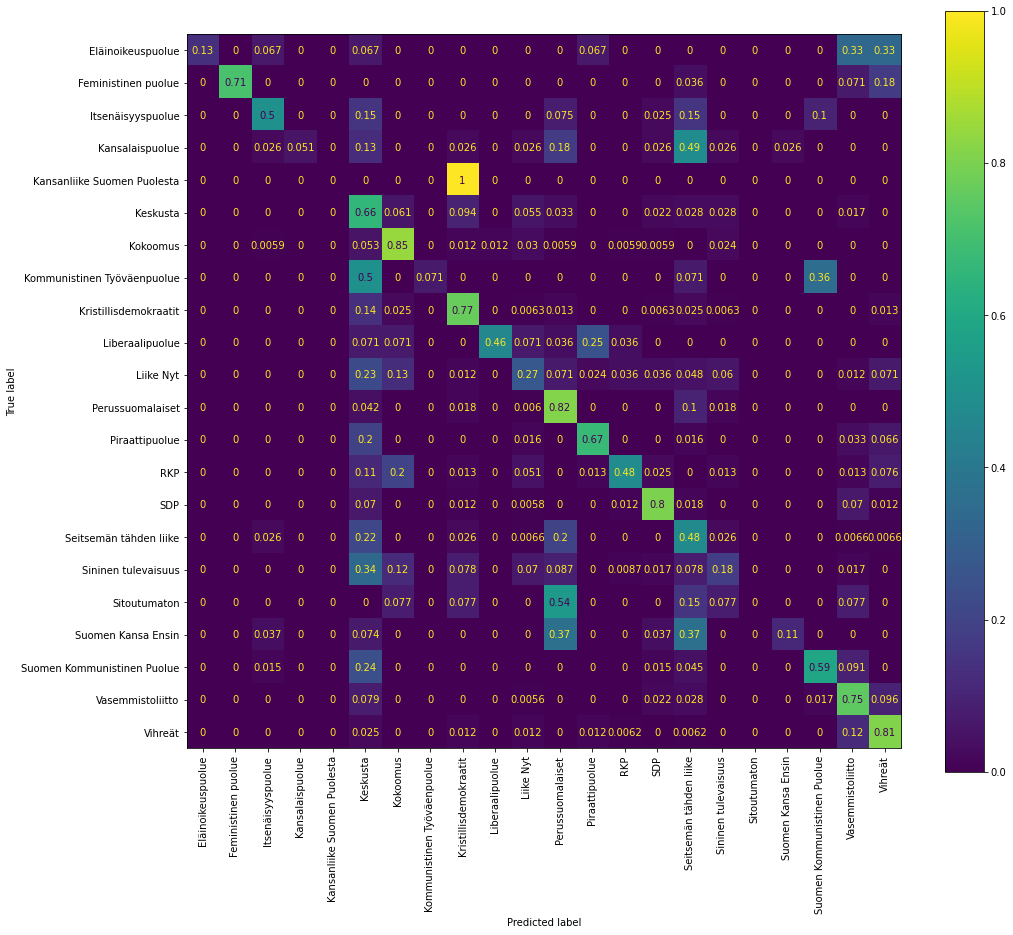

In [39]:
fig, ax = plt.subplots(figsize=(16,14))
plot_confusion_matrix(gs_svc, X_train, y_train, normalize='true', xticks_rotation='vertical', ax=ax)
plt.show()

In [85]:
test_pred = gs_svc.best_estimator_.predict(X_test)

In [151]:
acc = precision_score(y_test, test_pred, average='micro')
print(f"Accuracy with test data: {acc}")

Accuracy with test data: 0.5532786885245902


In [148]:
# This code is copied from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],3),       # rounding added
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


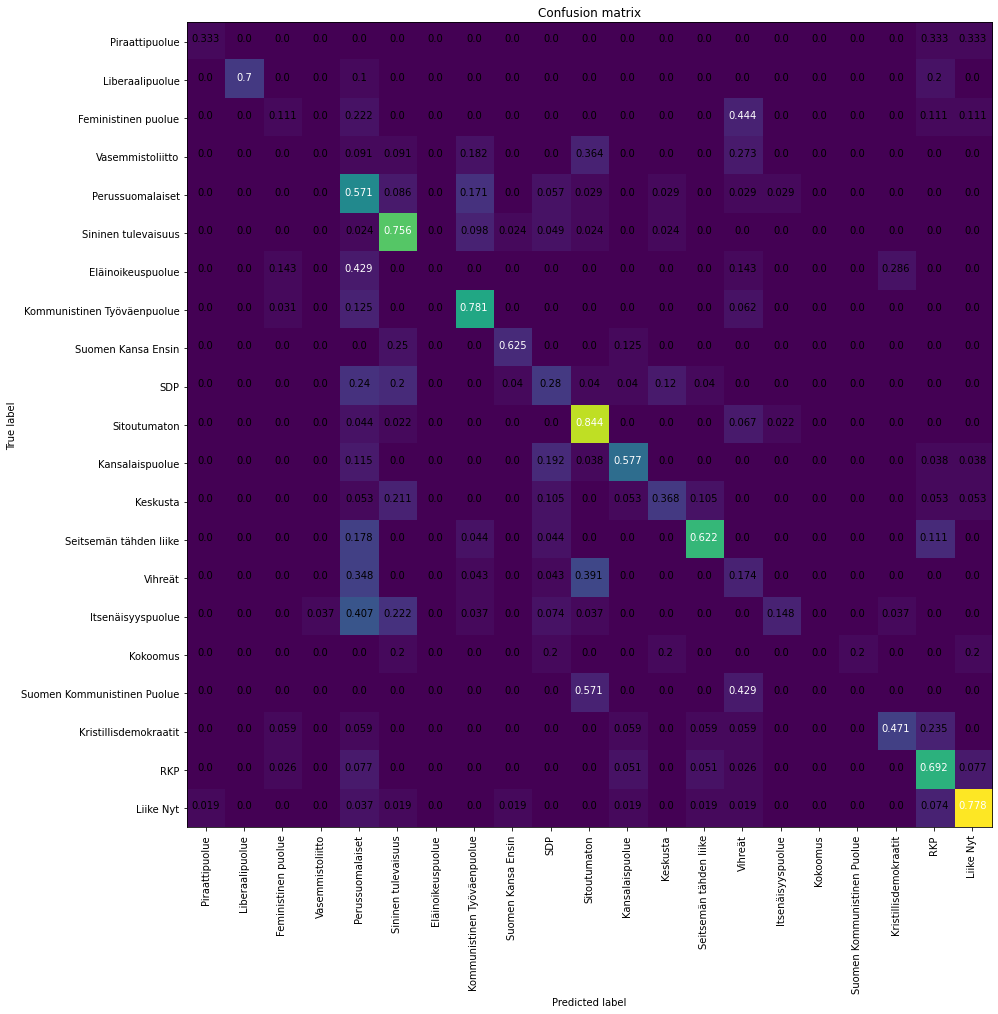

In [149]:
plt.figure(figsize=(16,14))
cm = confusion_matrix(y_true=y_test, y_pred=test_pred)
plot_confusion_matrix(cm, classes=set(y_test), normalize=True, cmap=plt.cm.viridis)
plt.show()

In [180]:
pca_scatter = PCA(n_components=3)
X_test_mean = SimpleImputer(missing_values=np.nan, strategy='mean').fit(X_test)
pca_scatter.fit(X_test_mean.transform(X_test))

PCA(n_components=3)

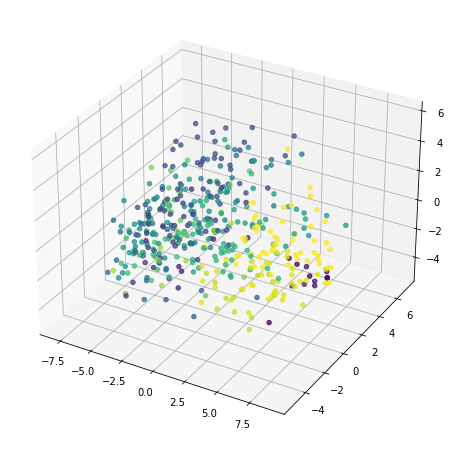

In [191]:
d = pca_scatter.transform(X_test_mean.transform(X_test))
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
sc = ax.scatter3D(d[:, 0], d[:, 1], d[:, 2], c=y_test.astype('category').cat.codes, alpha=.75)
plt.show()